# Base Classifier

by Michael Hunziker

## Summary
The aim of this notebook is to train a *Base Classifier* using TF-IDF and a standard ML classifier with default hyperparameters.

The aim of this notebook is to train a *Base Classifier* using TF-IDF and a standard ML classifier with default hyperparameters. This builds a *base line* upon which more advanced models (i.e. deep learning ones) should show better performance in order to be considered. Additionally, it also investigate the how much individual features (i.e. words) contribute to the class assignment (feature importance) in order to get an idea if the classifier makes *reasonable* decisions.

In a second step, this notebook uses hyperparameter tuning to automatically improve the performance of the Base Classifier.


*   Prepare Dataset


</br>

<a href="https://colab.research.google.com/github/miam-bonbon/assignment-adv-nlp/blob/main/adv_nlp_assignment_mh_03_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's do some imports

In [3]:
%%capture

!pip install 'fhnw-nlp-utils>=0.9.8,<0.10.0'

from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import load_dataframe

import pandas as pd
import numpy as np

from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.system import system_info

set_log_level()
print(system_info())

In [4]:
# create a DEV variable to use later
DEV = True

In [5]:
%%time

!rm "./data/COVIDSenti_tokenized_02.parq"

download("https://github.com/miam-bonbon/assignment-adv-nlp/raw/refs/heads/main/data/COVIDSenti_tokenized_02.parq", "data/COVIDSenti_tokenized_02.parq")
data = load_dataframe("data/COVIDSenti_tokenized_02.parq")
data.shape

rm: cannot remove './data/COVIDSenti_tokenized_02.parq': No such file or directory
CPU times: user 503 ms, sys: 97.1 ms, total: 600 ms
Wall time: 2.05 s


(22516, 8)

In [6]:
data.head(3)

,tweet,label,cleaned_tweet,lang,token_clean,token_no_stopwords_clean,text_clean,token_clean_tweet_tokenize
2,"TLDR: Not SARS, possibly new coronavirus. Diff...",neg,"TLDR: Not SARS, possibly new coronavirus. Diff...",en,"[tldr, :, sars, ,, possibly, new, coronavirus,...","[tldr, :, not, sars, ,, possibly, new, coronav...","tldr : sars , possibly new coronavirus . diffi...","[tldr, :, sars, ,, possibly, new, coronavirus,..."
8,@tezuma75 Why #CCP keep on saying unknown caus...,neg,Why #CCP keep on saying unknown cause of pneu...,en,"[#, ccp, keep, saying, unknown, cause, pneumon...","[why, #, ccp, keep, on, saying, unknown, cause...",# ccp keep saying unknown cause pneumonia ? ca...,"[#ccp, keep, saying, unknown, cause, pneumonia..."
11,I always feel weird hoping for another coronav...,neg,I always feel weird hoping for another coronav...,en,"[always, feel, weird, hoping, another, coronav...","[i, always, feel, weird, hoping, for, another,...",always feel weird hoping another coronavirus o...,"[always, feel, weird, hoping, another, coronav..."


We already removed neutral sentiments, since we classify binary

In [7]:
val_counts = data["label"].value_counts().sort_index()
val_counts

,count
label,
neg,16273
pos,6243


In [12]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, shuffle=True, random_state=43, stratify=data["label"])

X_train, y_train = data_train["text_clean"], data_train["label"]
X_test, y_test = data_test["text_clean"], data_test["label"]

# Now you have X_train, X_test, y_train, and y_test for your model training and evaluation
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16887,) (5629,) (16887,) (5629,)


We need our stopwords back

In [14]:
%%capture

if ('stopwords' not in locals()):
  !pip install 'spacy>=3.0.5'
  !pip install nltk
  from nltk.corpus import stopwords
  from nltk.stem.snowball import SnowballStemmer

  import spacy
  !python3 -m spacy download en_core_web_md

  nlp = spacy.load("en_core_web_md")

  import nltk
  nltk.download('punkt')
  nltk.download('stopwords')

  stemmer = SnowballStemmer("english")
  stopwords = set(stopwords.words("english"))
  #stopwords = set(nlp.Defaults.stop_words)
  empty_stopwords = set()

In [17]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

# we already preprocessed
pipe = Pipeline([
         ('vec', TfidfVectorizer()),
         ("clf", SGDClassifier(n_jobs=5))
        ])

pipe.fit(X_train, y_train)

CPU times: user 237 ms, sys: 0 ns, total: 237 ms
Wall time: 210 ms


Pipeline(steps=[('vec', TfidfVectorizer()), ('clf', SGDClassifier(n_jobs=5))])

In [18]:
%%time

y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

CPU times: user 327 ms, sys: 1.44 ms, total: 328 ms
Wall time: 428 ms


Let's get the classification report

In [19]:
from sklearn.metrics import classification_report

report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

Train:
              precision    recall  f1-score   support

         neg       0.96      0.99      0.97     12205
         pos       0.97      0.89      0.93      4682

    accuracy                           0.96     16887
   macro avg       0.96      0.94      0.95     16887
weighted avg       0.96      0.96      0.96     16887

Test:
              precision    recall  f1-score   support

         neg       0.93      0.98      0.95      4068
         pos       0.94      0.81      0.87      1561

    accuracy                           0.93      5629
   macro avg       0.93      0.89      0.91      5629
weighted avg       0.93      0.93      0.93      5629



And the confusion matrix

Set Population: 16887
Accuracy: 0.9603


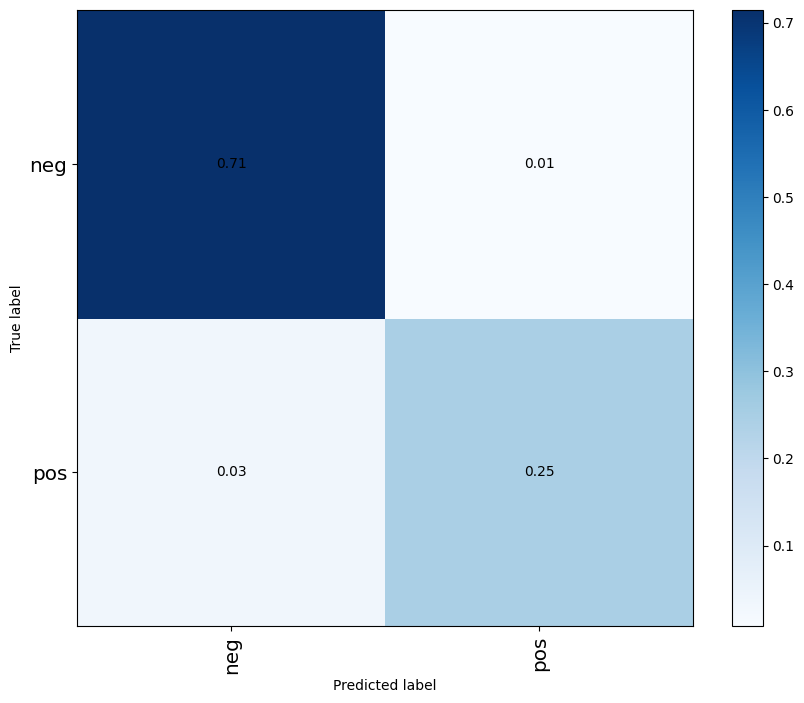

Set Population: 5629
Accuracy: 0.9311


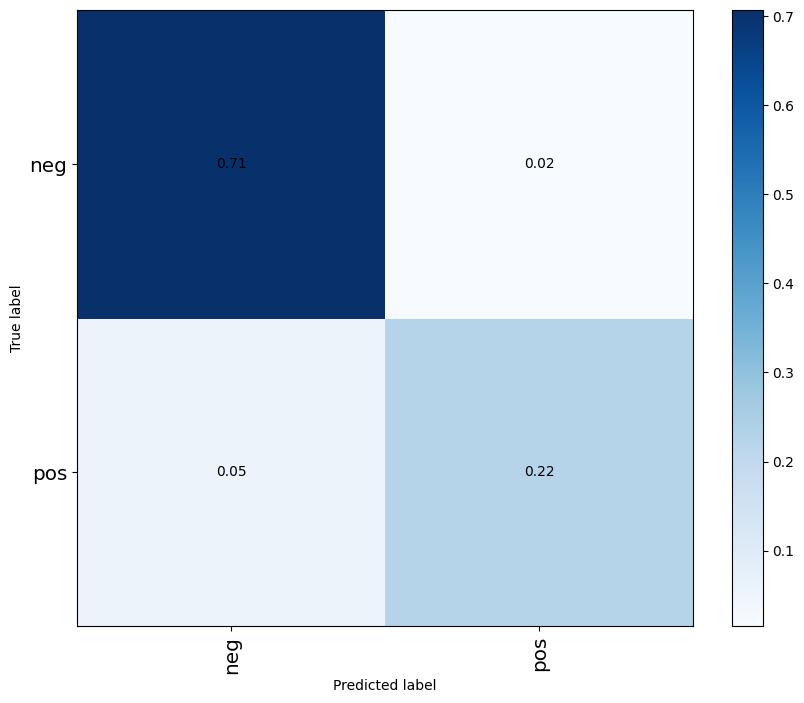

In [20]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix

plot_confusion_matrix(y_train.tolist(), y_train_pred)
plot_confusion_matrix(y_test.tolist(), y_test_pred)

Feature importance in order to get an idea if the class assignment builds on reasonable words

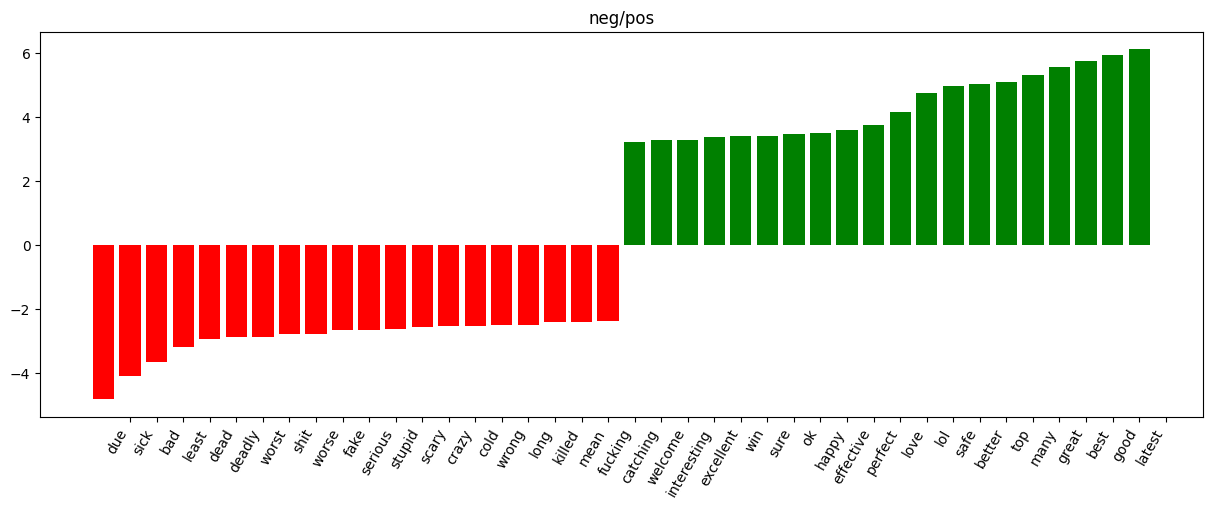

In [21]:
from fhnw.nlp.utils.ploting import plot_feature_importance

vectorizer = pipe.named_steps["vec"]
# only works since SGDClassifier uses LinearSVC by default
classifier = pipe.named_steps["clf"]

plot_feature_importance(classifier, vectorizer.get_feature_names_out())

This looks good! Let's get an impression on texts with wrong prediction

In [22]:
# Get the indices where the predictions are wrong
wrong_indices_test = np.where(y_test != y_test_pred)[0]

# Print some examples of wrongly classified texts
print("Examples of wrongly classified texts:")
for i in wrong_indices_test[:5]:  # Print the first 5 examples
    print(f"True Label: {y_test.iloc[i]}, Predicted Label: {y_test_pred[i]}")
    print(f"Text: {X_test.iloc[i]}")
    print("---")

Examples of wrongly classified texts:
True Label: pos, Predicted Label: neg
Text: covid- vaccine shipped , drug trials start | time see
---
True Label: pos, Predicted Label: neg
Text: cartoon film simpsons amazing , film parts describe coming corona virus , tr
---
True Label: neg, Predicted Label: pos
Text: search coronavirus several times day keep latest news . level stupidity stunning .
---
True Label: neg, Predicted Label: pos
Text: # thismorning bad news : coronavirus uk .good news : nobody mentioned brexit recently
---
True Label: pos, Predicted Label: neg
Text: nasa administrator statement coronavirus situation nasa : )
---
